In [466]:
import glob
import os
from datetime import datetime, timedelta, date
from os import path

from igraph import *

import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [467]:
# Various datasets to visualize

option = 3

if option == 1:
    base_folder = "./nhscovid"
    ext = "log" # Extension of log file, either log or txt
    ntot = 20   # Total number of participants
    vstep = 2   # Time step for visualization
    ostep = 1   # Time step for output to R
    infer_new_cases_from_inf = True # Time for "new case" is inferred either from infection or removal time
    asympt = 2  # Asymptomatic period
    sympt = 2   # Symptomatic period
    start_sim = datetime.strptime("2020-03-05 13:30", '%Y-%m-%d %H:%M')
    stop_sim = datetime.strptime("2020-03-05 14:15", '%Y-%m-%d %H:%M')
elif option == 2:    
    base_folder = "./furc222"
    ext = "log"
    ntot = 260
    vstep = 15
    ostep = 15
    infer_new_cases_from_inf = False
    asympt = 27
    sympt = 33
    start_sim = datetime.strptime("2020-02-22 7:30", '%Y-%m-%d %H:%M')
    stop_sim = datetime.strptime("2020-02-22 16:30", '%Y-%m-%d %H:%M')
elif option == 3:
    base_folder = "./sma125"
    ext = "txt"
    ntot = 200
    vstep = 5
    ostep = 5
    infer_new_cases_from_inf = True
    asympt = 20
    sympt = 10
    start_sim = datetime.strptime("2019-12-05 13:45", '%Y-%m-%d %H:%M')
    stop_sim = datetime.strptime("2019-12-05 15:30", '%Y-%m-%d %H:%M')
elif option == 4:
    base_folder = "./shanghai19"
    ext = "txt"
    ntot = 60
    vstep = 5
    ostep = 1
    infer_new_cases_from_inf = True
    asympt = 20
    sympt = 10
    start_sim = datetime.strptime("2019-09-10 21:30", '%Y-%m-%d %H:%M')
    stop_sim = datetime.strptime("2019-09-11 01:00", '%Y-%m-%d %H:%M')
elif option == 5:    
    base_folder = "./sma19"
    ext = "txt"
    ntot = 170
    vstep = 5
    ostep = 15
    infer_new_cases_from_inf = True
    asympt = 20
    sympt = 10
    start_sim = datetime.strptime("2019-03-14 13:30", '%Y-%m-%d %H:%M')
    stop_sim = datetime.strptime("2019-03-14 16:30", '%Y-%m-%d %H:%M')
elif option == 6:
    base_folder = "./broad15"
    ext = "log"
    ntot = 50
    vstep = 15
    ostep = 5
    infer_new_cases_from_inf = True
    asympt = 80
    sympt = 40
    start_sim = datetime.strptime("2019-12-10 09:00", '%Y-%m-%d %H:%M')
    stop_sim = datetime.strptime("2019-12-10 17:00", '%Y-%m-%d %H:%M')

In [468]:
# Some config

# Coded outcomes:
# 0 = not information
# 1 = became infected, but no outcome (yet) known
# 2 = recovered
# 3 = dead
# 4 = escaped
# 10 = infected others, but has not outcome, so it is considered an initial node
color_dict = {0: "Lime Green", 1: "Dark Orange", 2: "Dodger Blue", 3: "Black", 4:"Orchid", 10:"White"}    

data_folder = path.join(base_folder, "data")
output_folder = path.join(base_folder, "output")
if not path.exists(output_folder):
    os.mkdir(output_folder)
    
viz_delta = timedelta(minutes=vstep)
out_delta = timedelta(minutes=ostep)  

In [469]:
# Load all log files

files = [f for f in glob.glob(data_folder + "**/*." + ext, recursive=False)]

min_time = 1E10
max_time = 0
users = {}
inf_users = {}
inf_cases = []
noninf_cases = []
esc_cases = []
case0_count = 0
for fn in files:
    bname = path.basename(fn)
    idx = bname.rfind('-')
    case_id = bname[0:idx]
    events = []
    infected = False
    escaped = False    
    with open(fn, 'r') as f:
        lst = list(enumerate(f))
        n = len(lst)

        for i, line in lst:
            if i == 0 or i == n - 1:
                continue
            line = line.strip()
            line = line[1:-2]
            parts = line.split(',')
            time = int(parts[0].split(':')[1])
            date = datetime.fromtimestamp(time)
            if date < start_sim or stop_sim < date: continue

            evstr = parts[1]
            idx = evstr.find(':')
            evtyp = evstr[0:idx]
            if idx < len(evstr):
                evdat = evstr[idx+1:]
            else:
                evdat = None

            events += [{"time": time, "type": evtyp, "data": evdat}]
            
            if evtyp == "OUT" and evdat in ["DEAD", "RECOVERED"]:
                infected = True

            if evtyp == "OUT" and evdat == "ESCAPED":
                escaped = True                

            if evtyp == "INF":
                if "PEER" in evdat:
                    pstr = evdat[5:-1]
                    if ":" in pstr:
                        pieces = pstr.split(":")
                        pid = pieces[0]
                    else:
                        pid = pstr
                    if pid in inf_users:
                        inf_users[pid] = inf_users[pid] + 1
                    else:
                        inf_users[pid] = 1
                elif "CASE0" in evdat:
                    case0_count += 1
                
            min_time = min(min_time, time)
            max_time = max(max_time, time)            
    
    # Events are stored last to first in log files, reverting the order
    events.reverse()
    users[case_id] = events
    
    if infected:
        inf_cases += [case_id]
    else:
        noninf_cases += [case_id]
        if escaped:
            esc_cases += [case_id]

for pid in inf_users:
    if pid in noninf_cases:
        # This is a user that does not have an outcome but infected other users, 
        # so it is considered infected
        inf_cases += [pid]
        noninf_cases.remove(pid)
        
# The infected cases are indexed first, to facilitate removal of non-infected cases
# when plotting the tree-oriented network
count = 0
user_index = {}
for cid in inf_cases:
    user_index[cid] = count
    count += 1
for cid in noninf_cases:
    user_index[cid] = count
    count += 1

# At least there must be 1 initial case...
case0_count = max(case0_count, 1)
    
print("Number of infected    :", len(inf_cases))
print("Number of index cases :", case0_count)
print("Number of non-infected:", len(noninf_cases))
print("Number of escaped     :", len(esc_cases))

first_date = datetime.fromtimestamp(min_time)
last_date = datetime.fromtimestamp(max_time)
print("First event:", first_date)
print("Last event :", last_date)

Number of infected    : 37
Number of index cases : 1
Number of non-infected: 0
Number of escaped     : 0
First event: 2019-12-05 13:49:55
Last event : 2019-12-05 15:19:13


In [470]:
# The function in this cell constructs the infection network for a given time point

def construct_network(td0, td1, nt, fr = -1, log = False):
    inf_network = []
    user_outcome = [0] * nt
    
    ninf = 0
    nsurv = 0
    ndead = 0
    nesc = 0 
    nrem = 0
    nmiss = 0
    npeer = 0
    parents = {}
    first_inf = {}
    first_orph = {}
    infected = {}
    orphaned = {}
    for key in users:
        events = users[key]
        idx = user_index[key]
        if len(events) == 0: continue
        inft = None
        pkey = ""
        infect = None
        has_inf_event = False
        has_vax_event = False
        for ev in events:
            date = datetime.fromtimestamp(ev["time"])
            if td0:
                if date < td0 or td1 <= date: continue
            else:
                if td1 <= date: continue

            str_date = date.strftime('%H:%M:%S')
            data = ev["data"]
            if ev["type"] == "OUT":
                if data == "VACCINATED":
                    has_vax_event = True
                else:    
                    if data == "RECOVERED":
                        user_outcome[user_index[key]] = 2
                        nsurv += 1
                    elif data == "DEAD":
                        user_outcome[user_index[key]] = 3
                        ndead += 1
                    elif data == "ESCAPED":
                        user_outcome[user_index[key]] = 4
                        nesc += 1
                    else: 
                        print("Unrecognized outcome:", data)
                        
                    if has_inf_event:
                        nrem += 1
                    elif data != "ESCAPED":
                        nmiss += 1
                        
                    if not infect:
                        # Infection edge without origin
                        infect = [{"a":"unk", "b":key, "t":str_date, "s":"-"}]
                        orphaned[key] = date
            elif ev["type"] == "INF":
                inft = date
                if pkey:
                    # Duplicated parent, skipping
                    continue
                if "PEER" in data:
                    user_outcome[idx] = 1
                    pstr = data[5:-1]
                    if ":" in pstr:
                        pieces = pstr.split(":")
                        pkey = pieces[0]
                        strain = pieces[1]
                    else:
                        pkey = pstr
                        strain = "0"
                    if pkey in users:
                        if pkey in parents:
                            if date < parents[pkey]:
                                parents[pkey] = date
                        else:
                            parents[pkey] = date
                        infect = [{"a":pkey, "b":key, "t":str_date, "s": strain}]
                        npeer += 1
                        has_inf_event = True
                    else:
                        infect = [{"a":"unk", "b":key, "t":str_date, "s": strain}]
                        has_inf_event = False
                elif "CASE0" in data:
                    user_outcome[idx] = 10
                    strain = data[6:-1]
                    infect = [{"a":"zero", "b":key, "t":str_date, "s": strain}]
                    has_inf_event = True
                    first_inf[idx] = date
                elif "SOURCE" in data:
                    user_outcome[idx] = 10
                    if ":" in data:
                        strain = pieces[1]
                    else:
                        strain = "0"
                    infect = [{"a":"src", "b":key, "t":str_date, "s": strain}]
                    has_inf_event = True
                    first_inf[idx] = date
                    
        if has_vax_event: 
            continue
            
        if has_inf_event:
            ninf += 1
            
        infected[idx] = has_inf_event

        if infect:
            inf_network += infect

    if log:
        print("  Total number of infected:", ninf)
        print("  Total number of deaths:", ndead) 
        print("  Total number of survivors:", nsurv)
        print("  Total number of escaped:", nesc) 
        print("  Total number of infected & removed:", nrem)
        print("  Number of infections from peer:", npeer)
        print("  Number of infections with missing source:", nmiss)

    # Finalizing outcomes and first infections based on ancilliary info
    
    for p in parents:
        idx = user_index[p]
        if user_outcome[idx] == 0:
            # This user infected others but not yet had an outcome, so marked as initial node (10)
            user_outcome[idx] = 10
        if not idx in infected or not infected[idx]:
            # Not infected by anybody else, so it is a first case
            first_inf[idx] = parents[p]

    for o in orphaned:
        # Orphan nodes are those who had an outcome but not infecting parent, 
        # and did not infected anybody else
        idx = user_index[o]
        if not idx in first_inf:
            first_inf[idx] = orphaned[o]

    return inf_network, user_outcome, first_inf, ninf, nrem

In [471]:
# Plot infection network using igraph
# https://igraph.org/python/

td = start_sim
frame = 0
while td <= stop_sim:
    print("-> Processing frame:", frame, "- Time:", td)
    network, outcomes, _, _, _ = construct_network(start_sim, td, ntot, frame)
    td += viz_delta

    g = Graph(directed=True)
    g.add_vertices(ntot)

    g.vs["outcome"] = outcomes
    g.vs["color"] = [color_dict[out] for out in g.vs["outcome"]]

    for edge in network:
        n0 = edge["a"]
        n1 = edge["b"]
        if n0 in user_index and n1 in user_index:
            g.add_edges([(user_index[n0], user_index[n1])])

    layout = g.layout("fr")
    p = plot(g, os.path.join(output_folder, "frame-" + str(frame) + td.strftime('-%H-%M') + ".pdf"), 
             layout = layout, vertex_size = 9, edge_arrow_width = 1, edge_arrow_size = 0.5, bbox=(0, 0, 800, 800))

    frame += 1

-> Processing frame: 0 - Time: 2019-12-05 13:45:00
-> Processing frame: 1 - Time: 2019-12-05 13:50:00
-> Processing frame: 2 - Time: 2019-12-05 13:55:00
-> Processing frame: 3 - Time: 2019-12-05 14:00:00
-> Processing frame: 4 - Time: 2019-12-05 14:05:00
-> Processing frame: 5 - Time: 2019-12-05 14:10:00
-> Processing frame: 6 - Time: 2019-12-05 14:15:00
-> Processing frame: 7 - Time: 2019-12-05 14:20:00
-> Processing frame: 8 - Time: 2019-12-05 14:25:00
-> Processing frame: 9 - Time: 2019-12-05 14:30:00
-> Processing frame: 10 - Time: 2019-12-05 14:35:00
-> Processing frame: 11 - Time: 2019-12-05 14:40:00
-> Processing frame: 12 - Time: 2019-12-05 14:45:00
-> Processing frame: 13 - Time: 2019-12-05 14:50:00
-> Processing frame: 14 - Time: 2019-12-05 14:55:00
-> Processing frame: 15 - Time: 2019-12-05 15:00:00
-> Processing frame: 16 - Time: 2019-12-05 15:05:00
-> Processing frame: 17 - Time: 2019-12-05 15:10:00
-> Processing frame: 18 - Time: 2019-12-05 15:15:00
-> Processing frame: 1

In [472]:
# Plot tree-orientated network

network, outcomes, initial, _, _ = construct_network(start_sim, stop_sim, ntot, log = True)

seeds = []
for s in initial:
    seeds += [s]

succeptibles = []
for idx in range(ntot):
    if outcomes[idx] == 0:
        succeptibles += [idx]
    if outcomes[idx] == 10:
        seeds += [idx]
        
# print(outcomes)
# print(seeds)
# print(succeptibles)

g = Graph(directed=True)
g.add_vertices(ntot)

g.vs["outcome"] = outcomes
g.vs["color"] = [color_dict[out] for out in g.vs["outcome"]]

for edge in network:
    n0 = edge["a"]
    n1 = edge["b"]
    if n0 in user_index and n1 in user_index:
        g.add_edges([(user_index[n0], user_index[n1])])

# Removing non-infected, assuming they are all after the infected
g.delete_vertices(succeptibles)
        
layout = g.layout("rt", mode="out", root = seeds, rootlevel = [1] * len(seeds))
p = plot(g, os.path.join(output_folder, "infection-tree.pdf"), 
         layout = layout, vertex_size = 16, edge_arrow_width = 1, edge_arrow_size = 0.9, bbox=(0, 0, 800, 800))

  Total number of infected: 30
  Total number of deaths: 25
  Total number of survivors: 12
  Total number of escaped: 0
  Total number of infected & removed: 30
  Number of infections from peer: 30
  Number of infections with missing source: 7


[200, 200, 200, 200, 200, 199, 199, 187, 176, 175, 173, 173, 173, 172, 172, 171, 171, 170, 170, 170, 170, 170]
[0, 0, 0, 0, 0, 1, 0, 12, 11, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 10, 22, 24, 26, 26, 27, 28, 28, 29, 29, 30, 30, 30]
[0, 0, 0, 0, 0, 1, 1, 13, 24, 25, 27, 27, 27, 28, 28, 29, 29, 30, 30, 30, 30, 30]


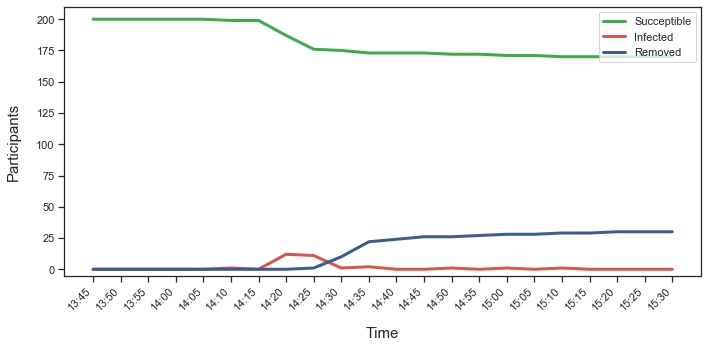

<Figure size 432x288 with 0 Axes>

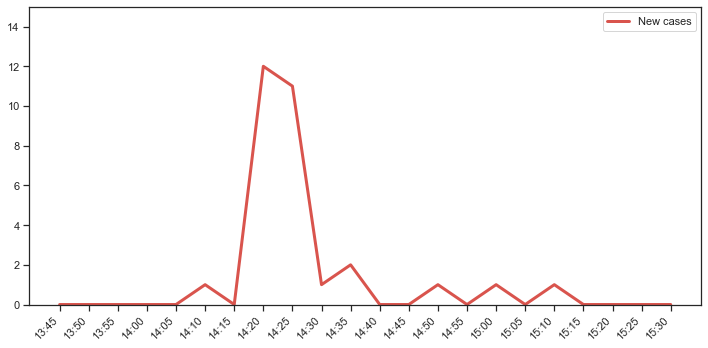

<Figure size 432x288 with 0 Axes>

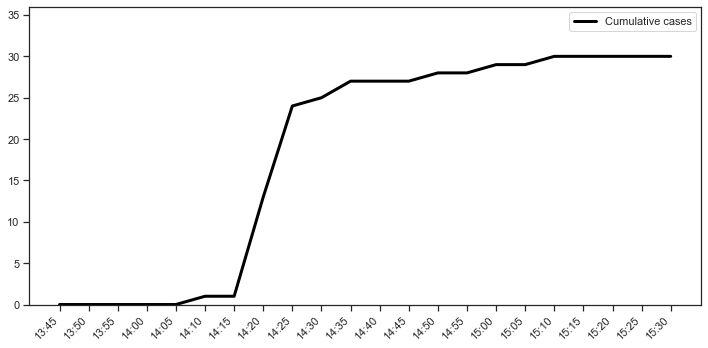

In [473]:
# Plot epi curves

# Styling with seaborn:
# https://seaborn.pydata.org/tutorial/aesthetics.html

sns.set()
sns.set_style("ticks")

S = []
I = []
R = []
C = []
time = []
tlabels = []

td = start_sim
ninf0 = 0
t = 0
while td <= stop_sim:
    _, _, _, ninf, nrem = construct_network(start_sim, td, ntot)

    if infer_new_cases_from_inf:
        # New cases are inferred from the infection time forward
        n = ninf
    else:
        # New cases are inferred from the removal time backwards
        n = nrem    
    
    dinf = n - ninf0
    ninf0 = n
    
    S += [ntot - n]
    
    I += [dinf]
    R += [nrem]
    C += [n]    
    
    time += [t]
    tlabels += [td.strftime('%H:%M')]
    td += viz_delta
    t += 1

if infer_new_cases_from_inf:
    d = int(asympt/vstep)
    S = [ntot] * d + S[0:len(S) - d]
    I = [0] * d + I[0:len(I) - d]
    C = [0] * d + C[0:len(C) - d]
else:    
    d = int(sympt/vstep)
    S = S[d:len(S)] + [S[len(S) - 1]] * d
    I = I[d:len(I)] + [0] * d
    C = C[d:len(C)] + [C[len(C) - 1]] * d

print(S)
print(I)
print(R)
print(C)

# Combined SIR curves
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([-5, ntot + 10])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(time, S, label="Succeptible", color=sns.xkcd_rgb["medium green"], lw=3)
ax.plot(time, I, label="Infected", color=sns.xkcd_rgb["pale red"], lw=3)
ax.plot(time, R, label="Removed", color=sns.xkcd_rgb["denim blue"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "epi-curves.pdf"))

# New cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I) * 1.2)])
ax.plot(time, I, label="New cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-cases-curve.pdf"))

# Cumulative cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(C) * 1.2)])
ax.plot(time, C, label="Cumulative cases", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(time, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "cumulative-curve.pdf"))

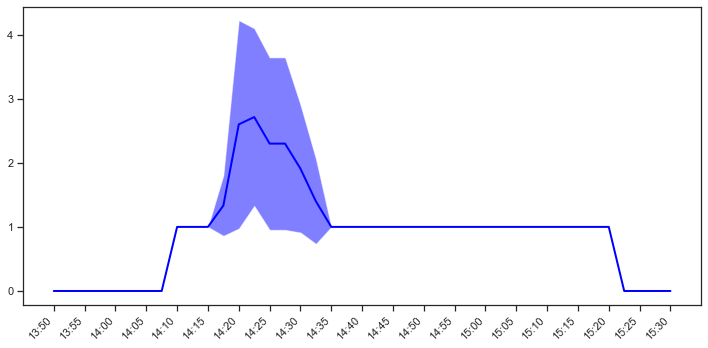

In [474]:
td0 = start_sim
viz_delta2 = timedelta(minutes=vstep/2)
td = td0 + viz_delta
ninf0 = 0
t = 0
r_mean_values = []
r_std_values = []
tlabels = []
while td <= stop_sim:
    network, _, _, _, _ = construct_network(td0, td, ntot)
    
    inf_counts = {}
    for edge in network:
        n0 = edge["a"]
        if n0 not in ["unk", "zero", "src"]:
            if n0 in inf_counts:
                inf_counts[n0] = inf_counts[n0] + 1
            else:
                inf_counts[n0] = 1

    r_values = []
    for node in inf_counts:
        r_values += [inf_counts[node]]

    if r_values:
        r_mean = np.mean(r_values)
        r_std = np.std(r_values)
        r_mean_values += [r_mean]
        r_std_values += [r_std]
    else:
        r_mean_values += [0]
        r_std_values += [0]
    
    td0 = td - 2 * viz_delta
    tlabels += [td.strftime('%H:%M')]    
    td += viz_delta2
    
# Shifting forward because the calculation above is done at the time of infection    
d = int(2*asympt/vstep)
r_mean_values = [0] * d + r_mean_values[0:len(r_mean_values) - d]
r_std_values = [0] * d + r_std_values[0:len(r_std_values) - d]
    
mu = np.array(r_mean_values)
sigma = np.array(r_std_values)
time = np.arange(len(sigma))
    
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, mu, lw=2, label='R', color='blue')
ax.fill_between(time, mu+sigma, mu-sigma, facecolor='blue', alpha=0.5)

time2 = time[0::2]
tlabels2 = tlabels[0::2]
plt.xticks(time2, tlabels2, rotation=45, horizontalalignment="right")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "r-time-curve.pdf"))

[3, 5, 3, 4, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]
1.875 1.2686114456365274


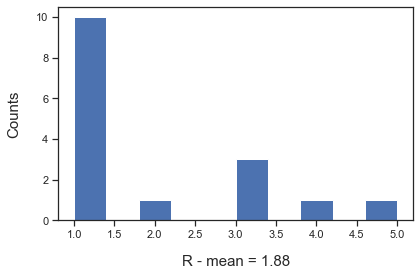

In [475]:
# Plot distribution of R averaged over the entire simulation

network, _, _, _, _ = construct_network(start_sim, last_date + viz_delta, ntot, log = False)

inf_counts = {}
for edge in network:
    n0 = edge["a"]
    if n0 not in ["unk", "zero", "src"]:
        if n0 in inf_counts:
            inf_counts[n0] = inf_counts[n0] + 1
        else:
            inf_counts[n0] = 1

r_values = []
for node in inf_counts:
    r_values += [inf_counts[node]]
print(r_values)

r_mean = np.mean(r_values)
r_std = np.std(r_values)

print(r_mean, r_std)

counts, bins = np.histogram(r_values)
plt.ylabel("Counts", labelpad=15, fontsize=15)
plt.xlabel("R - mean = " + str(round(r_mean, 2)), labelpad=15, fontsize=15)
plt.hist(bins[:-1], bins, weights=counts)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "r-mean-histogram.pdf"))

In [476]:
# Save case data and parameters for analysis in R

rows = []

td = start_sim
ninf0 = 0
t = 0
while td <= stop_sim:
    _, _, _, ninf, nrem = construct_network(start_sim, td, ntot)

    if infer_new_cases_from_inf:
        n = ninf
    else:
        n = nrem    
    
    dinf = n - ninf0
    ninf0 = n
    
    rows += [{"Count": dinf,
              "Time": t}]
    t += 1
    td += out_delta

case_data = pd.DataFrame(rows)
case_data.to_csv(os.path.join(output_folder, "case_counts.csv"), index = False)

param_data = pd.DataFrame([{"T":t, "dT":ostep, "N":ntot, "I0":case0_count}])
param_data.to_csv(os.path.join(output_folder, "input_params.csv"), index = False)